In [1]:
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import matplotlib.pyplot as plt
from speechcolab.datasets.gigaspeech import GigaSpeech

from lhotse import CutSet, Fbank, LilcomFilesWriter
from lhotse.augmentation import SoxEffectTransform, RandomValue, pitch, reverb, speed
from lhotse.dataset import K2SpeechRecognitionDataset
from lhotse.dataset.sampling import SingleCutSampler
from lhotse.recipes.gigaspeech import prepare_gigaspeech

# Settings for paths

In [2]:
root_dir = Path('data')
corpus_dir = root_dir / 'GigaSpeech'
output_dir = root_dir / 'gigaspeech_nb'

# Select data parts

In [3]:
train_set = '{XS}'

In [4]:
dataset_parts = (train_set, '{TEST}')

# Download the data

In [5]:
gigaspeech = GigaSpeech(corpus_dir)

In [6]:
for part in dataset_parts:
    # TODO: remove this try-except block in the stable version
    try:
        gigaspeech.download(part)
    except NotImplementedError:
        assert gigaspeech.json_path.is_file()

# Prepare audio and supervision manifests

In [7]:
num_jobs = os.cpu_count()

In [8]:
gigaspeech_manifests = prepare_gigaspeech(gigaspeech, dataset_parts, output_dir, num_jobs=num_jobs)

In [9]:
gigaspeech_manifests

{'{XS}': {'recordings': RecordingSet(len=79),
  'supervisions': SupervisionSet(len=15304)},
 '{TEST}': {'recordings': RecordingSet(len=131),
  'supervisions': SupervisionSet(len=25619)}}

# [Optional] Data augmentation

In [10]:
use_data_augmentation = False
augment_fn = SoxEffectTransform(effects=[
   ['reverb', 50, 50, RandomValue(0, 100)],
   ['remix', '-'],  # Merge all channels (reverb changes mono to stereo)
   ['rate', 16000],
]) if use_data_augmentation else None

# Extract features

In [11]:
for partition, manifests in gigaspeech_manifests.items():
    manifest_path = output_dir / f'cuts_{partition}.json.gz'
    if not manifest_path.is_file():
        with ProcessPoolExecutor(num_jobs) as ex:
            cut_set = CutSet.from_manifests(
                recordings=manifests['recordings'],
                supervisions=manifests['supervisions']
            )
            if use_data_augmentation:
                cut_set = cut_set + cut_set.perturb_speed(0.9) + cut_set.perturb_speed(1.1)
            cut_set = cut_set.compute_and_store_features(
                extractor=Fbank(),
                storage_path=f'{output_dir}/feats_{partition}',
                storage_type=LilcomFilesWriter,
                augment_fn=augment_fn,
                num_jobs=num_jobs,
                executor=ex
            )
        gigaspeech_manifests[partition]['cuts'] = cut_set
        cut_set.to_json(manifest_path)
    gigaspeech_manifests[partition] = CutSet.from_json(manifest_path)

# Make PyTorch Dataset

In [12]:
dataset_test = K2SpeechRecognitionDataset(gigaspeech_manifests['{TEST}'])
dataset_train = K2SpeechRecognitionDataset(gigaspeech_manifests[train_set])

# Illustration of an example

In [13]:
sampler = SingleCutSampler(dataset_test.cuts, shuffle=False, max_cuts=4)
cut_id = next(iter(sampler))[0]
sample = dataset_test[[cut_id]]

In [14]:
seg_id = 1
text = sample['supervisions']['text'][seg_id]
start_frame = int(sample['supervisions']['start_frame'][seg_id])
end_frame = start_frame + int(sample['supervisions']['num_frames'][seg_id]) - 1
feats = sample['inputs'][0][start_frame:end_frame, :]

Transcript: THIS TIME IS THE MOST CRUCIAL IT'S BEEN THE ENTIRE YEAR <PERIOD>
Supervisions start frame: 917
Supervisions end frame: 1265
Feature matrix:


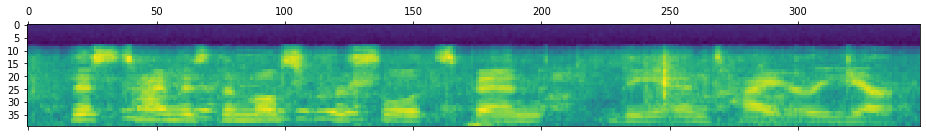

In [15]:
print('Transcript:', text)
print('Supervisions start frame:', start_frame)
print('Supervisions end frame:', end_frame)
print('Feature matrix:')
plt.matshow(feats.transpose(0, 1).flip(0));